# Redes totalmente convolucionais

Este notebook aborda os seguintes aspectos relacionados às redes totalmente convolucionais:
- como transformar uma camada densa em convolucional, aproveitando seus pesos;
- como criar, a partir de uma rede pré-treinada para classificar imagens, uma rede totalmente convolucional;
- demonstrar que uma rede totalmente convolucional, quando aplicada em imagens maiores que aquelas usadas em seu treinamento, implementa uma varredura implícita com ganhos de eficiência.
- apresentar um método para aumentar a resolução (*shift-and-stitch*)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import time
import numpy as np
import argparse

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils
from sklearn import datasets

import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:     {}'.format(K.backend()))
print('Data format: {}'.format(K.image_data_format()))

print('Keras ', keras.__version__)
print('Numpy ', np.__version__)

Using TensorFlow backend.


Backend:     tensorflow
Data format: channels_first
Keras  2.0.3
Numpy  1.11.3


In [2]:
# Para demonstrar a técnica shift e stitch
def show_scan(M, H, W):
    from IPython import display
    def printt(arr):
        for line in output.tolist():
            print(' '.join([' abcdefghijklmnop'[x] for x in line]))

    M = 36
    image = np.zeros((1, 1, M, M))

    lab = 1
    output = np.zeros((M-H+1, M-W+1), np.uint8)
    for i in range(4):
        for j in range(4):
            oo = output[i::4, j::4]
            output[i::4, j::4] = lab * np.ones_like(oo)
            print('origin: ({}, {}), shape: {}, label: {}'.format(i, j, oo.shape, ' abcdefghijklmnop'[lab]))
            print()
            printt(output)
            lab += 1
            time.sleep(2)
            display.clear_output(wait=True)

# Função para criar uma imagem de teste, maior que 28x28 colocando várias amostras
def make_image(X_test, y_test, M=200, H=28, W=28):
    M = 200
    char_index = np.random.choice(X_test.shape[0], 10, replace=False)
    char_img = [img.reshape(H,W) for img in (255*X_test).astype(np.uint8)[char_index]]
    char_lab = [y for y in y_test[char_index]]

    image = np.zeros((M, M), np.uint8)
    coords = [(0, 0), (50, 150), (100, 100), (171, 171), (120,30)] # posição das imagens na imagem maior
    xlabel = []
    for k, (i, j) in enumerate(coords):
        image[i:i+H, j:j+W] = char_img[k]
        xlabel.append(char_lab[k])
    return image, coords, xlabel

### MNIST dataset

In [3]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)
H = W = 28
n_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, H, W) / 255.0
X_test = X_test.reshape(-1, 1, H, W) / 255.0

y_train_oh = np_utils.to_categorical(y_train, 10)
y_test_oh = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
print(y_train_oh.shape, y_test_oh.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)
(60000, 10) (10000, 10)


## Pequena amostra apenas para testar o código

In [4]:
n_samples_train = 1000
n_samples_test  = 500

X_train = X_train[:n_samples_train]
y_train_oh = y_train_oh[:n_samples_train]
X_test = X_test[:n_samples_test]
y_test = y_test[:n_samples_test]
y_test_oh = y_test_oh[:n_samples_test]

## Carregando nosso modelo pre-treinado

In [5]:
print("[INFO] loading model...")
model_name = '../../models/keras_lenet_1'
model_A, histo_A = load_model_and_history(model_name)  # Modelo A é a rede do exercício anterior, com camadas densas no final

print(model_A.summary())

[INFO] loading model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 7, 7)       

In [6]:
print(X_test.shape, y_test_oh.shape)

(500, 1, 28, 28) (500, 10)


In [7]:
print("[INFO] evaluating...")
loss, accuracy = model_A.evaluate(X_test, y_test_oh, batch_size=128, verbose=0)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] evaluating...
[INFO] accuracy: 92.00%


## Modelo totalmente convolucional equivalente

O modelo seguinte é todo ele convolucional.

A primeira camada densa do modelo tem como entrada um tensor de dimensão 2450, resultante do redimensionamento (via *Flatten*) da saída do *Dropout*, 50x7x7. Esta camada gera uma saída com dimensão 500. Seus pesos têm portanto dimensão 2450x500.

Uma camada convolucional que substitua estas camadas *Flatten* e *Dense* terá como entrada um tensor 50x7x7. Para gerar uma saída 500x1x1, a convolução deve criar 500 mapas com um kernel 7x7 e com borda do tipo 'valid'.

Para substituir a última camada densa, usamos uma convolução com 10 mapas e kernel 1x1.


<table align='left'>
<tr><td colspan=2> <img src="../figures/fully_conv_5.png" alt="Drawing" style="width: 700px;"/> </td></tr>
</table>

### Observando o shape dos pesos da rede original

O Keras adota a seguinte convenção para o *shape* dos kernels das camadas convolucionais:
 - (wh,ww,channels,nb_filters):

In [8]:
W_all_A = model_A.get_weights()
print([w.shape for w in W_all_A])

[(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (2450, 500), (500,), (500, 10), (10,)]


In [109]:
model_name = '../../models/keras_lenet_fullconv'

class FullConvNet:
    @staticmethod
    def build():
        model = Sequential()
        
        model.add(Conv2D( 20, (5, 5), padding="same", 
                             batch_input_shape=(None, 1, None, None)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D( 50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Conv2D(500, (7, 7), padding="valid"))        
        model.add(Activation("relu"))

        model.add(Conv2D( 10, (1, 1), padding="valid"))        
        return model

model_B = FullConvNet.build()  # Modelo B é o totalmente convolucional
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 20, None, None)    520       
_________________________________________________________________
activation_19 (Activation)   (None, 20, None, None)    0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, None, None)    0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 50, None, None)    25050     
_________________________________________________________________
activation_20 (Activation)   (None, 50, None, None)    0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, None, None)    0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 500, None, None)   1225500   
__________

## Ajustando os pesos do modelo todo convolucional

<table align='left'>
<tr><td colspan=2> <img src="../figures/fully_conv_6.png" alt="Drawing" style="width: 700px;"/> </td></tr>
</table>


In [110]:
W_all_B = model_B.get_weights()

print([w.shape for w in W_all_A])
print([w.shape for w in W_all_B])



[(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (2450, 500), (500,), (500, 10), (10,)]
[(5, 5, 1, 20), (20,), (5, 5, 20, 50), (50,), (7, 7, 50, 500), (500,), (1, 1, 500, 10), (10,)]


In [111]:
W_all_B = [
    W_all_A[0], # pesos da primeira convolução 5x5
    W_all_A[1], # bias da primeira convolução 5x5
    W_all_A[2], # pesos da segunda convolução 5x5
    W_all_A[3], # bias da segunda convolução
    np.rollaxis(np.rollaxis(W_all_A[4].T.reshape(500,50,7,7), 1, 4), 0, 4),
    W_all_A[5], # bias desta camada
    np.rollaxis(np.rollaxis(W_all_A[6].T.reshape(10,500,1,1), 1, 4), 0, 4),
    W_all_A[7], # bias desta camada
]
model_B.set_weights(W_all_B)

## Verificando a performance

In [112]:
def softmax(Z, axis=-1):
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=axis,keepdims=True)
    return S


y_hat_oh_score = model_B.predict(X_test)[0][0]
y_hat_oh = softmax(y_hat_score.reshape(n_samples_test,n_classes))
#print(y_hat_oh.max(1)[:5])
y_hat = np.argmax(y_hat_oh, axis=1)
print(y_hat.shape)

y_hat_A = model_A.predict_classes(X_test)
print(y_hat_A.shape)

(500,)
500/500 [==============================] - 1s     
(500,)


In [113]:
print(y_test[:10])
print(y_hat[:10])
print(y_hat_A[:10])

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [114]:
print(100.0 * (y_hat == y_test).astype(np.int).sum() / y_test.shape[0])
print(100.0 * (y_hat_A == y_test).astype(np.int).sum() / y_test.shape[0])

92.0
92.0


## Janela deslizante

Agora que temos uma rede toda convolucional, vejamos o que acontece se a imagem de entrada é maior que as imagens utilizadas para treinamento (28x28).

A figura abaixo, ilustra o processo mostrando as dimensões dos *features* através de uma linha da imagem de entrada com dimensões 36x36. Acompanhemos cada passo:

- imagem de entrada (representada na figura em uma dimensão apenas): 1x36x36;
- convolução 20 filtros 5x5, borda *'same'*: 20x36x36
- maxpool 2x2, stride 2x2: 20x18x18
- convolução 50 filtros 5x5, borda *'same'*: 50x18x18
- maxpool 2x2, stride 2x2: 50x9x9
- convolução 500 filtros 7x7, borda *'valid'*: 500x3x3
- convolução 10 filtros 1x1: 10x3x3

<table align='left'>
<!-- <tr><td> <img src="../figures/fully_conv_4.png" alt="Drawing" style="width: 200px;"/> </td> <td/></tr> -->
<tr><td colspan=2> <img src="../figures/fully_conv_3.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

In [115]:
M = 200
image, coords, xlabel = make_image(X_test, y_test_oh, M, H, W) # Construindo uma imagem para testes M x M com 4 dígitos

0.999814510345


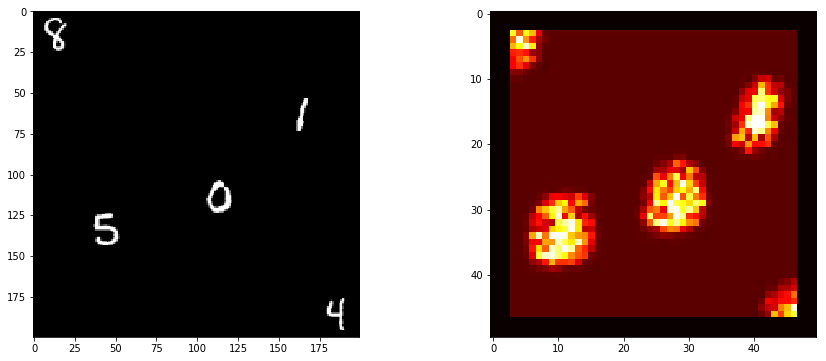

In [117]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(image, cmap='gray')

in_image = image.astype(np.float32).reshape(1, 1, M, M) / 255.0  # Preparando a imagem para entrar na rede

img_hat_oh = model_B.predict(in_image)[0]  # Rede totalmente convolucional em execução

img_hat = softmax(img_hat_oh, axis=0)
pmax = img_hat.max(axis=0)
hm = np.zeros(np.array(pmax.shape)+6,np.float)
hm[3:-3, 3:-3] = pmax

fig.add_subplot(1,2,2)
plot.imshow(hm, cmap=plot.cm.hot);
print(hm.max())

**Atenção:** Observe que as duas imagens acima possuem resolução (*shape*) diferentes. A resolução da imagem de entrada, mostrada à esquerda, é de (200,200) e a resolução da imagem de saída (à direita) é de (50,50).

## Aumentando a resolução

Demonstrando a técnica de *shift* e *stitch*

In [118]:
show_scan(M, H, W) # Demonstração da varredura e preenchimento (shift, stitch)

origin: (3, 3), shape: (2, 2), label: p

a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a
e f g h e f g h e
i j k l i j k l i
m n o p m n o p m
a b c d a b c d a


0 0 (10, 44, 44)
0 1 (10, 44, 43)
0 2 (10, 44, 43)
0 3 (10, 44, 43)
1 0 (10, 43, 44)
1 1 (10, 43, 43)
1 2 (10, 43, 43)
1 3 (10, 43, 43)
2 0 (10, 43, 44)
2 1 (10, 43, 43)
2 2 (10, 43, 43)
2 3 (10, 43, 43)
3 0 (10, 43, 44)
3 1 (10, 43, 43)
3 2 (10, 43, 43)
3 3 (10, 43, 43)
0.0 0.999858
(173, 173)


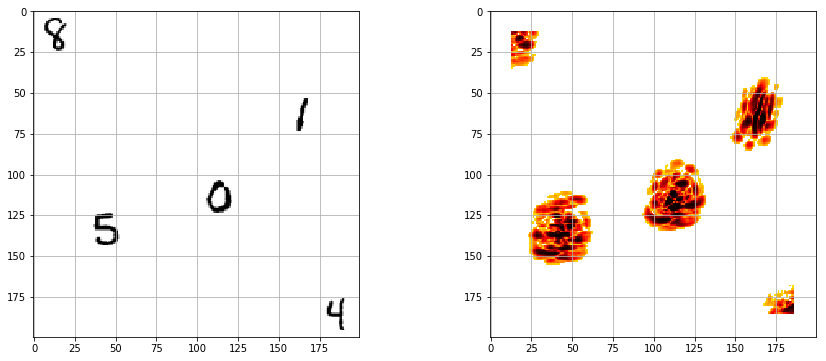

In [124]:
fig = plot.figure(figsize=(15,6)) 

fig.add_subplot(1,2,1)
plot.imshow(255 - image, cmap=plot.cm.gray)
plot.grid(True)

# Aplicando a técnica shift e stitch na imagem
# A rede convolucional é aplicada na imagem, 16 vezes para
# preencher os dados
output = np.zeros((10, M-H+1, M-W+1), np.float32)
for i in range(4):
    for j in range(4):
        output[:, i::4, j::4] = oo = model_B.predict(in_image[:, :, i:, j:])[0] # Execução da rede
        print(i, j, oo.shape)

output = softmax(output, axis=0)
pmax = output.max(0)
imax = output.argmax(0)
pmax = np.where(pmax < 0.3, 0, pmax)
print(pmax.min(), pmax.max())
print(pmax.shape)

phm = np.zeros((M,M), pmax.dtype)
phm[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = pmax

ihm = np.zeros((M,M), imax.dtype)
ihm[(H+1)//2-1:-H//2, (W+1)//2-1:-W//2] = imax

fig.add_subplot(1,2,2)
plot.imshow(255 * (1.0 - phm), cmap=plot.cm.hot)
# plot.imsave('heatmap.png', 255 * pmax)
plot.grid(True)

In [125]:
for k, (i, j) in zip(xlabel, coords):
    for m in (-1, 0, 1):
        for n in (-1, 0, 1):
            print('p = {:.5f}, char: \'{}\' [correct: \'{}\']'.format(phm[i+m+13, j+n+13], 
                                                                      ihm[i+m+13, j+n+13], k), end=' ')
            if m == n == 0:
                print('**')
            else:
                print()
    print()

p = 0.00000, char: '0' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.00000, char: '0' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.00000, char: '0' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.00000, char: '0' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.78060, char: '8' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] **
p = 0.85157, char: '8' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.00000, char: '0' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.82326, char: '8' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 
p = 0.71826, char: '8' [correct: '[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]'] 

p = 0.96365, char: '1' [correct: '[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]'] 
p = 0.99879, char: '1' [correct: '[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]'] 
p = 0.99490, char: '1' [correct: '[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]'] 
p = 0.99759, char: '1' [correct: '[ 0.  1.  0.  0

## Observações

- A rede base utilizada não foi treinada para a não-ocorrência de um dos dez caracteres, nem de recortes parciais dos caracteres originais.
- Um exercício interessante seria treinar o modelo com os caracteres sobrepostos a imagens de fundo, além de recortes do fundo sem caracter (11 classes).


## Aprendizados com este notebook
